In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import xarray as xr
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from sklearn.linear_model import LinearRegression

import matplotlib.patches as mpatches
from physoce import tseries as ts 
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy import stats
from scipy.signal import periodogram
from datetime import timedelta

# Spectral analysis and turbulent dissipation estimates
- Additional QC of adv data is used to flag data runs (bursts of data) that have gaps of high correlation and signal strength (SNR)
- Parameters for dissipation QC are used from Fedderson, 2010 ("Quality controlling surf zone acoustic Doppler velocimeter observations to estimate the turbulent dissipation rate")
    - SNR on each beam should be > 15dB
    - CORR on each beam should be above .3 + .4(SQRT(f_s/f_max)), where f_s is the instrument sampling frequency, and f_max is the maximum sampling frequency the instrument is capable of 
    - Fraction of "bad data" to good data for each run is determined as sigmaSS and sigmaCORR
        - sigmaSS <= .1 (34560/38400 data points, or two minutes of "bad data" allowed)
        - sigmaCORR <= .7 (11520/38400 data points, or 14 minutes of "bad data" allowed)
    - Bad data runs that do not meet these criteria are discarded, and the remaining good data runs are "fixed"
        - Gaps in data <= 1s long are linearly interpolated between the good data points bounding the gap
        - Longer gaps are averaged and the entire gap is set to the averaged value
        - If the gap is significantly longer than a couple seconds, "patching" may be used
        - Patching removes the larger gaps in data and joins the good data points together, but may cause bias via time shifting in the frequency spectra

In [ ]:
def e_data_filter(ds):
    # Check for sigmaSS and sigmaCORR in both adv datasets
    # ySS = 15, yCORR = .5

    # Start by filtering data that doesn't pass the SNR test
    print('Filtering SNR')
    ySS = xr.zeros_like(ds.East)
    ySS = ySS + xr.where((ds.SNR_B1 >= 15), 0, 1)
    ySS = ySS + xr.where((ds.SNR_B2 >= 15), 0, 1)
    ySS = ySS + xr.where((ds.SNR_B3 >= 15), 0, 1)
    ySS = ds.where(ySS < 1)
    ySS['Burst_number'] = ds.Burst_number
    ySS['Pressure'] = ds.Pressure
    print('Finding number of good bursts')
    ndata = ySS.groupby('Burst_number').count().Vertical
    sigSS = np.array([np.unique(ySS.Burst_number), ndata])
    sigSS = np.where(sigSS[1] >= (38400*.9), sigSS[0], np.nan)
    sigSS = sigSS[~np.isnan(sigSS)]
    print('Creating gdat')
    gdat = ySS.where(ySS.Burst_number.isin(sigSS), drop=True)

    # Then filter data that doesn't pass the correlation test, but use the gdat dataset
    print('Filtering correlation')
    yCORR = xr.zeros_like(gdat.East)
    yCORR = yCORR + xr.where((gdat.Correlation_B1 >= 15), 0, 1)
    yCORR = yCORR + xr.where((gdat.Correlation_B2 >= 15), 0, 1)
    yCORR = yCORR + xr.where((gdat.Correlation_B3 >= 15), 0, 1)
    yCORR = gdat.where(yCORR < 1)
    yCORR['Burst_number'] = gdat.Burst_number
    yCORR['Pressure'] = gdat.Pressure
    print('Finding number of good bursts')
    ndata = yCORR.groupby('Burst_number').count().Vertical
    sigCORR = np.array([np.unique(yCORR.Burst_number), ndata])
    sigCORR = np.where(sigCORR[1] >= (38400*.3), sigCORR[0], np.nan)
    sigCORR = sigCORR[~np.isnan(sigCORR)]
    print('Creating gdat')
    gdat = yCORR.where(yCORR.Burst_number.isin(sigCORR), drop=True)
    gdat = gdat.drop(labels=['CSPD', 'CDIR', 'Checksum', 'Dat_flag'])
    
    return gdat

In [3]:
#e1 = e_data_filter(adv1)
#e1.to_netcdf('ADV/e1.nc')
e1 = xr.open_dataset('ADV/e1.nc')
adv1 = xr.open_dataset('ADV/adv1_dat.nc')

#e2 = e_data_filter(adv2)
#e2.to_netcdf('ADV/e2.nc')
e2 = xr.open_dataset('ADV/e2.nc')
adv2 = xr.open_dataset('ADV/adv2_dat.nc')

In [5]:
# Gaps in the quality controlled data still exist but can be fixed/trimmed to generate more complete data runs

# Gaps of 1 second can be linearly interpolated between start and end points of gap
delta = timedelta(seconds=1, milliseconds = 31.25) # Maximum gap of less than 1 second and 31.25 milliseconds
e1_inter = e1.interpolate_na(dim="time", method="linear", max_gap = delta) # Linearly interpolates across gaps up to a limit denoted by time delta

# Interpolate_na cannot estimate data gaps without start or end points, or gaps exceeding the time delta
gaps = e1_inter.where(e1_inter.East.isnull() == True, drop = True) # Generate a dataset with all leftover uninterpolated gaps

# Gaps leftover due to lack of start/end points should be removed, whereas gaps longer than a second can be fixed
# Manually select bad and good bursts
badgaps = [5, 36, 104] # Droppable data
goodgaps = [77] # Fixable

badtimes = np.array(gaps.time.where(gaps.Burst_number.isin(badgaps), drop = True)) # Create an array of times from bad bursts to remove from dataset
e1_inter = e1_inter.drop(badtimes, dim='time') # Drop the bad times

goodtimes = np.array(gaps.time.where(gaps.Burst_number.isin(goodgaps), drop = True)) # Create an array of times from fixable bursts to remove from dataset

#Burst 77 has two different gaps greater than time delta, so they must be corrected separately
b1 = goodtimes[0:40]
b2 = goodtimes[40:]

# Fixable gaps are mitigated by using the original adv data to find the average velocity over the time gap
Eastm1 = np.mean(adv1.East.sel(time = slice(b1[0], b1[-1])))
Northm1 = np.mean(adv1.North.sel(time = slice(b1[0], b1[-1])))
Vertm1 = np.mean(adv1.Vertical.sel(time = slice(b1[0], b1[-1])))

Eastm2 = np.mean(adv1.East.sel(time = slice(b2[0], b2[-1])))
Northm2 = np.mean(adv1.North.sel(time = slice(b2[0], b2[-1])))
Vertm2 = np.mean(adv1.Vertical.sel(time = slice(b2[0], b2[-1])))

# Using the xr.where function, the averages are applied to the proper time gaps for each component of velocity
east = xr.where(e1_inter.East.time.isin(b1), Eastm1, e1_inter.East)
east = xr.where(e1_inter.East.time.isin(b2), Eastm2, east)
e1_inter['East'] = east

north = xr.where(e1_inter.North.time.isin(b1), Northm1, e1_inter.North)
north = xr.where(e1_inter.North.time.isin(b2), Northm2, north)
e1_inter['North'] = north

vert = xr.where(e1_inter.East.time.isin(b1), Vertm1, e1_inter.Vertical)
vert = xr.where(e1_inter.East.time.isin(b2), Vertm2, vert)
e1_inter['Vertical'] = vert

<ipython-input-5-3ec692842046>:16: DeprecationWarning: dropping labels using list-like labels is deprecated; using dict-like arguments with `drop_sel`, e.g. `ds.drop_sel(dim=[labels]).
  e1_inter = e1_inter.drop(badtimes, dim='time') # Drop the bad times


In [120]:
e1_inter.to_netcdf('ADV/e1_inter.nc')

In [112]:
# Now do it for second turbulent dissipation dataset

delta = timedelta(seconds=1, milliseconds = 31.25) # Maximum gap of less than 1 second and 31.25 milliseconds
e2_inter = e2.interpolate_na(dim="time", method="linear", max_gap = delta) # Linearly interpolates across gaps up to a limit denoted by time delta

# Interpolate_na cannot estimate data gaps without start or end points, or gaps exceeding the time delta
gaps = e2_inter.where(e2_inter.East.isnull() == True, drop = True) # Generate a dataset with all leftover uninterpolated gaps
gaps

<xarray.Dataset>
Dimensions:         (time: 11375)
Coordinates:
  * time            (time) datetime64[ns] 2022-08-15T08:59:59.937500 ... 2022...
Data variables:
    Burst_number    (time) float64 3.0 3.0 22.0 22.0 ... 365.0 365.0 365.0 365.0
    East            (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    North           (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    Vertical        (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    SNR_B1          (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    SNR_B2          (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    SNR_B3          (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    Correlation_B1  (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    Correlation_B2  (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    Correlation_B3  (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    Pressure        (time) float64 9.175 9.155 10.09 10.09 ... 10.1 10.1 10.09
Attributes:
    description:  ADV data

In [129]:
tdiff = np.diff(gaps.time, axis = 0, prepend = gaps.time[0])/1000000

In [263]:
gap_count = 0
times = np.array(gaps.time)
gap_times_list = []
gap_count_list = []
final_time = times[-1]
for i in range(len(tdiff)):
    if np.int(tdiff[i]) <= 32:
        start_time = times[i-gap_count]
        gap_count = gap_count + 1
    elif (np.int(tdiff[i]) > 32) | (i == len(tdiff)):
        gap_times_list.append([start_time, times[i-1]])
        gap_count_list.append(gap_count)
        gap_count = 0

In [264]:
counts = np.array(gap_count_list)
gap_times = np.array(gap_times_list)

In [252]:
goodtimes = []
badtimes = []
for i in range(len(counts)):
    if counts[i] <= 32:
        badtimes.append(gap_times[i])
    else:
        goodtimes.append(gap_times[i])

In [ ]:
gap_times

In [249]:
tdiff[11300:11374]

array([      31,       31,       31,       31,       31,  3717000,
        3600000, 28301125,       31,       31,       31,       31,
             31,       31,       31,       31,       31,       31,
             31,       31,       31,       31,       31,       31,
             31,       31,       31,       31,       31,       31,
             31,       31,       31,       31,       31,       31,
             31,       31,       31,       31,       31,       31,
             31,       31,       31,       31,       31,       31,
             31,       31,       31,       31,       31,       31,
             31,       31,       31,       31,       31,       31,
             31,       31,       31,       31,       31,       31,
             31,       31,       31,       31,       31,       31,
             31,       31], dtype='timedelta64[ns]')

### Spectral analysis

In [3]:
e1_inter = xr.open_dataset('ADV/e1_inter.nc')
temp = xr.open_dataset('Temperature/temp_w_rho.nc')

In [4]:
# THE FOLLOWING CODE IS ADAPTED FROM STEVEN CUNNINGHAM'S MASTERS THESIS (2019)

# Rotate velocity data along the principle axes U and V
theta, major, minor = ts.princax(e1_inter.East, e1_inter.North) # theta = angle, major = SD major axis (U), SD minor axis (V)
U, V = ts.rot(e1_inter.East, e1_inter.North, -theta)
e1_inter['U'] = U
e1_inter['V'] = V
# Vertical velocity is the W component

In [5]:
from scipy.optimize import curve_fit
def power_law(x, a, b):
    return a*np.power(x, b)

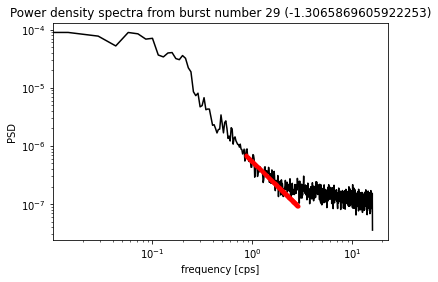

In [8]:
#blist = np.unique(e1_inter.Burst_number)
blist = [29]
for i in range(len(blist)):
    burst_number = blist[i]
    burst = e1_inter.where(e1_inter.Burst_number.isin(burst_number), drop = True)

    # Smoothing out the spectra
    F_hanning, S_hanning = welch(burst.Vertical, fs=32, nperseg= 2240, window='hanning', detrend='linear') # Feddderson uses 70s windows (70 * 32Hz = 2240 point segments)
    # Fit the dummy power-law data
    pars, cov = curve_fit(f=power_law, xdata=F_hanning[60:200], ydata=S_hanning[60:200], p0=[0, 0], bounds=(-np.inf, np.inf))
    stdevs = np.sqrt(np.diag(cov))
    slope_line = pars[0]*(F_hanning[60:200]**(-5/3))

    plt.figure()
    plt.title('Power density spectra from burst number ' + str(burst_number) + ' (' + str(pars[1]) + ')')
    plt.loglog(F_hanning, S_hanning, '-k')
    plt.loglog(F_hanning[60:200], slope_line, '.r')
    plt.xlabel('frequency [cps]')
    plt.ylabel('PSD')

### Good bursts for estimating turbulent dissipation in deployment 1
- 8, 9?, 14?, 29, 30, 41?, 42???, 45, 52, 59, 64, 75, 76, 77

In [ ]:
# Function for estimating k from wave period and total depth using dispersion relationships
def wavedisp(wavper,h):
    """ 
    (omega,k,Cph,Cg) = wavedisp(wavper,h)
    ------------------
    Returns [omega,k,Cph,Cg]

    Inputs (can use arrays): 
            wavper - wave period [s]
            h - water depth [m]
   
    Outputs: 
    omega - angular wave frequency [radians/s]
    k - angular wave number	 [radians/m]
    Cph - phase speed [m/s]
    Cg - group velocity [m/s]
    """

    """ T Connolly 2014
    based on Matlab function wavedisp.m from S Lentz """
    # make sure inputs are arrays
    wavper=np.array(wavper)
    h=np.array(h)
    
    omega = (2*np.pi)/wavper
    g = 9.8
    c = omega**2*h/g
    
    x = np.sqrt(c)
    
    d = 100*np.ones(np.shape(wavper))
    tol = 5.*np.finfo(float).eps
    while (d>tol).any():
        f1=x*np.tanh(x)-c
        f2=x*(1/np.cosh(x))**2+np.tanh(x)
        x=x-f1/f2
        d=np.abs((c-x*np.tanh(x))/c)
    k=x/h
    Cph=omega/k
    Cg=(g*x*(1/np.cosh(x))**2+g*np.tanh(x))/(2*np.sqrt(g*k*np.tanh(x)))
    
    return (omega,k,Cph,Cg)

In [106]:
# Filtering out waves from spectra

# Select data run to be filtered
burst = e1_inter.where(e1_inter.Burst_number.isin(52), drop = True) # Burst 52 is best spectra so far

# Since the goal is to find the specific spectra of waves, a spectrum of pressure is used over vertical velocity
Fp, Sp = welch(burst.Pressure, fs=32, nperseg= 2240, window='hanning') # Pressure spectra
Fw, Sw = welch(burst.Vertical, fs=32, nperseg= 2240, window='hanning') # Vertical velocity spectra

# Required variables for conversion:

# Gravity
g = 9.8

# Density
rho = np.mean(temp.Rho.sel(time=slice(burst.time[0], burst.time[-1])))+1000

# Depth
H = np.mean(burst.Pressure) + .578 # Mean pressure detected by the sensor plus the height of sensor from the bottom

# Depth of pressure sensor
Zp = -(np.mean(burst.Pressure))

# Depth of velocity sensor
Zv = (-H) + .824 # Total depth plus the height of the velocity transducers from the bottom

# Period
T = 1/Fp

# Omega (radian frequency) and wavenumber (k)
omega,k,Cph,Cg = wavedisp(T, H)

# Generate empty arrays for p' and w' values
p_prime = np.empty(len(omega))
w_prime = np.empty(len(omega))

for i in range(len(omega)): # For loops iterates over all values of omega
    p_prime[i] = (rho*g)*(np.cosh(k[i]*(Zp+H))/np.cosh(k[i]*H))
    w_prime[i] = (-omega[i])*(np.sinh(k[i]*(Zv+H)))/(np.sinh(k[i]*H))
scale_factor = w_prime**2 / p_prime**2

Sw_from_Sp = (Sp * scale_factor)*100000000

<ipython-input-106-497e43374b93>:28: RuntimeWarning: divide by zero encountered in true_divide
  T = 1/Fp
<ipython-input-30-8bf9e13ee0b9>:35: RuntimeWarning: invalid value encountered in true_divide
  x=x-f1/f2
<ipython-input-30-8bf9e13ee0b9>:34: RuntimeWarning: overflow encountered in cosh
  f2=x*(1/np.cosh(x))**2+np.tanh(x)
<ipython-input-30-8bf9e13ee0b9>:39: RuntimeWarning: overflow encountered in cosh
  Cg=(g*x*(1/np.cosh(x))**2+g*np.tanh(x))/(2*np.sqrt(g*k*np.tanh(x)))
C:\Users\Chili\anaconda\lib\site-packages\xarray\core\computation.py:724: RuntimeWarning: overflow encountered in cosh
  result_data = func(*input_data)
C:\Users\Chili\anaconda\lib\site-packages\xarray\core\computation.py:724: RuntimeWarning: overflow encountered in sinh
  result_data = func(*input_data)
C:\Users\Chili\anaconda\lib\site-packages\xarray\core\computation.py:724: RuntimeWarning: overflow encountered in multiply
  result_data = func(*input_data)
<ipython-input-106-497e43374b93>:40: RuntimeWarning: divid

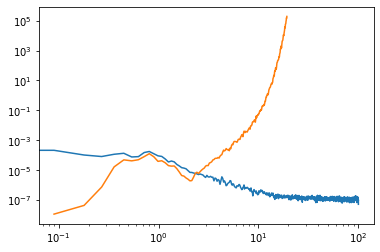

In [107]:
plt.figure()
plt.loglog(omega, Sw) # Original vertical velocity spectra
plt.loglog(omega, Sw_from_Sp) # velocity spectra estiamted from pressure

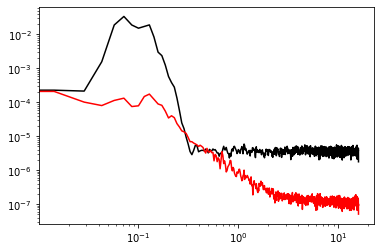

In [101]:
plt.figure()
plt.loglog(Fp, Sp, '-k')
plt.loglog(Fw, Sw, '-r')

In [100]:
.

array([0.00000000e+00, 1.42857143e-02, 2.85714286e-02, ...,
       1.59714286e+01, 1.59857143e+01, 1.60000000e+01])

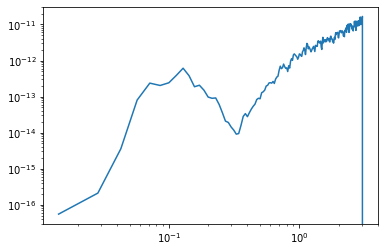

In [84]:
plt.figure()
plt.loglog(Fp, Sw_from_Sp)

In [38]:
T = 
H = np.float(np.mean(burst.Pressure) + .578)

<ipython-input-38-17f8b15df904>:1: RuntimeWarning: divide by zero encountered in true_divide
  T = 1/Fp


<ipython-input-30-8bf9e13ee0b9>:35: RuntimeWarning: invalid value encountered in true_divide
  x=x-f1/f2
<ipython-input-30-8bf9e13ee0b9>:34: RuntimeWarning: overflow encountered in cosh
  f2=x*(1/np.cosh(x))**2+np.tanh(x)
<ipython-input-30-8bf9e13ee0b9>:39: RuntimeWarning: overflow encountered in cosh
  Cg=(g*x*(1/np.cosh(x))**2+g*np.tanh(x))/(2*np.sqrt(g*k*np.tanh(x)))
